In [73]:
import pandas as pd
import numpy as np

In [74]:
data_path = '../clustering/gem_candidates_soft.csv'
df = pd.read_csv(data_path)
print(f'columns: {df.columns}')
df

columns: Index(['business_id', 'stars', 'review_count', 'attr_score', 'cat_score',
       'avg_review_stars', 'std_review_stars_scaled', 'pos_review_ratio',
       'neg_review_ratio', 'neu_review_ratio', 'long_review_ratio',
       'avg_review_length_scaled', 'avg_word_count_scaled',
       'avg_useful_scaled', 'avg_funny_scaled', 'avg_cool_scaled',
       'interact_score_mean_scaled', 'sentiment_score_mean_scaled',
       'first_review_date', 'last_review_date', 'recent_review_ratio',
       'review_timespan_days_scaled', 'review_density_per_day_scaled',
       'review_burst_score_scaled', 'avg_user_avg_stars', 'elite_user_ratio',
       'avg_user_account_age_days', 'avg_user_review_count_log_scaled',
       'avg_user_useful_log_scaled', 'avg_user_funny_log_scaled',
       'avg_user_cool_log_scaled', 'avg_user_fans_log_scaled',
       'avg_user_compliments_log_scaled', 'gem_label'],
      dtype='object')


,business_id,stars,review_count,attr_score,cat_score,avg_review_stars,std_review_stars_scaled,pos_review_ratio,neg_review_ratio,neu_review_ratio,...,avg_user_avg_stars,elite_user_ratio,avg_user_account_age_days,avg_user_review_count_log_scaled,avg_user_useful_log_scaled,avg_user_funny_log_scaled,avg_user_cool_log_scaled,avg_user_fans_log_scaled,avg_user_compliments_log_scaled,gem_label
0,il_Ro8jwPlHresjw9EGmBg,-1.132288,-0.212222,6.5,1.670499,2.413793,0.776556,0.448276,0.379310,0.172414,...,3.072069,0.172414,-0.875370,-0.819606,-0.778717,-1.033356,-0.647838,-0.889185,-0.525681,0
1,qhDdDeI3K4jy2KyzwFN53w,0.383586,-0.121393,0.0,1.000000,4.052632,-0.294102,0.605263,0.078947,0.315789,...,4.029737,0.631579,1.144675,1.419795,1.500704,1.589323,1.493492,1.751805,1.518337,1
2,kfNv-JZpuN6TVNSO6hHdkw,0.383586,-0.284884,2.5,1.000000,3.950000,0.515631,0.750000,0.100000,0.150000,...,4.003500,0.250000,-1.674202,0.135378,-0.065015,-0.173017,-0.074152,-0.423573,-0.281522,0
3,x1mhq4IpWctQOBM06dU8vg,-2.142871,-0.239470,0.5,1.692475,1.600000,0.036412,0.280000,0.600000,0.120000,...,2.148800,0.040000,-1.743473,-1.965375,-1.567713,-1.487938,-1.922442,-1.315666,-1.999048,0
4,seKihQKpGGnCeLuELRQPSQ,-0.121706,1.867748,5.5,2.185136,3.333333,0.525084,0.518519,0.211111,0.270370,...,3.611852,0.255556,-0.321709,0.125148,0.827640,0.988959,1.010086,-0.197925,0.322949,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5330,2f1ZnZg7730yChhV24ARJw,-0.121706,-0.066896,0.0,1.381861,3.346939,0.496569,0.428571,0.265306,0.306122,...,3.660612,0.346939,-0.085839,0.159726,0.208484,0.743959,0.339780,0.322353,0.582125,0
5331,AM7O0cwkxm6w_e0Q7-f9FQ,0.383586,-0.203139,0.0,1.381861,3.866667,0.558162,0.633333,0.233333,0.133333,...,3.778333,0.366667,-1.488153,-0.101261,-0.306420,-0.299942,-0.240725,-0.332186,-0.332175,0
5332,Gi1QPLu_y8rLS3uTN9Z_VA,-0.626997,-0.357547,0.0,1.000000,3.083333,1.526495,0.500000,0.500000,0.000000,...,3.125000,0.083333,-0.005377,-0.278233,-0.632478,-0.440149,-0.813292,-0.558896,-0.932551,0
5333,fn3ybdsRSrIDpKZTsRuAWg,0.383586,-0.357547,0.0,2.208772,4.083333,0.853708,0.750000,0.250000,0.000000,...,3.890000,0.083333,1.851451,-0.627310,-0.471674,-0.359534,-0.366096,-0.501931,-0.635779,0


In [75]:
df_cluster1 = df[df['gem_label'] == 1].copy()

In [76]:
def assign_initial_score(row, star_mean, count_median, count_q25, count_q75):
    if row['avg_review_stars'] < star_mean or row['review_count'] > count_median:
        return 0.0
    elif row['avg_review_stars'] >= 4.5 and row['review_count'] <= count_q25:
        return 1.0
    elif row['avg_review_stars'] >= 4.2 and row['review_count'] <= count_median:
        return 0.8
    elif row['avg_review_stars'] >= 4.0 and row['review_count'] <= count_q75:
        return 0.6
    elif row['avg_review_stars'] < 4.0 and row['interact_score_mean_scaled'] > 0.5:
        return 0.4
    else:
        return 0.2

# 加权加分
def enhance_score(row, base_score):
    bonus = 0
    bonus += 0.05 if row['review_burst_score_scaled'] > 0.5 else 0
    bonus += 0.05 if row['sentiment_score_mean_scaled'] > 0.5 else 0
    bonus += 0.05 if row['elite_user_ratio'] > 0.05 else 0
    bonus += 0.05 if row['interact_score_mean_scaled'] > 0.5 else 0
    bonus += 0.05 if row['attr_score'] > 1.0 else 0
    bonus += 0.05 if row['cat_score'] > 1.5 else 0

    return base_score + bonus


In [77]:
star_mean = df['avg_review_stars'].mean()
count_median = df['review_count'].median()
count_q25 = df['review_count'].quantile(0.25)
count_q75 = df['review_count'].quantile(0.75)
df_cluster1['initial_score'] = df_cluster1.apply(assign_initial_score, axis=1, args=(star_mean, count_median, count_q25, count_q75))
# df_cluster1['initial_score'] = df_cluster1['initial_score'].astype(float)

df_cluster1['gem_score'] = df_cluster1.apply(lambda row: enhance_score(row, row['initial_score']), axis=1)
# df_cluster1['gem_score'] = df_cluster1['gem_score'].astype(float)

df_cluster1

,business_id,stars,review_count,attr_score,cat_score,avg_review_stars,std_review_stars_scaled,pos_review_ratio,neg_review_ratio,neu_review_ratio,...,avg_user_account_age_days,avg_user_review_count_log_scaled,avg_user_useful_log_scaled,avg_user_funny_log_scaled,avg_user_cool_log_scaled,avg_user_fans_log_scaled,avg_user_compliments_log_scaled,gem_label,initial_score,gem_score
1,qhDdDeI3K4jy2KyzwFN53w,0.383586,-0.121393,0.0,1.000000,4.052632,-0.294102,0.605263,0.078947,0.315789,...,1.144675,1.419795,1.500704,1.589323,1.493492,1.751805,1.518337,1,0.0,0.10
5,lOP3HxdUTaq0eXhwR_KC-w,0.383586,-0.348464,1.5,1.372295,4.214286,-0.678362,0.571429,0.071429,0.357143,...,1.769483,1.880781,1.739639,1.498471,1.669280,1.547253,1.269424,1,0.8,0.90
6,7clCBgNbd-x2Wj96lZ6Mjw,0.888877,0.795973,2.5,1.353752,4.524138,-0.946519,0.779310,0.048276,0.172414,...,1.446761,0.850100,0.745090,0.709651,0.725381,0.767462,0.600842,1,0.0,0.15
8,jiLGdnf42eYftkqfU2ze1w,-0.121706,-0.203139,0.5,1.386337,3.366667,0.719490,0.500000,0.366667,0.133333,...,0.876350,0.979356,1.355009,1.952407,1.475703,0.996450,2.002127,1,0.0,0.10
9,Q3kQYhkYxSRyYyeBgtk--A,1.394168,-0.421127,2.5,1.000000,4.800000,-1.548796,0.600000,0.000000,0.400000,...,1.436311,1.416629,1.656833,1.543166,1.621489,1.526880,1.347747,1,1.0,1.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5287,jSSaOCOS8wnmrOUUOz3hpw,0.383586,-0.402961,0.0,1.947163,4.142857,0.652610,0.428571,0.000000,0.571429,...,-0.503585,1.033539,0.675450,0.704248,0.631011,0.718291,0.575278,1,0.6,0.70
5309,Y0EG7hB8aSeAk1PRvD_HpQ,0.383586,0.950381,0.0,1.987947,4.129630,0.137377,0.722222,0.135802,0.141975,...,1.642004,1.041847,1.161948,1.634708,1.207023,1.292743,1.446711,1,0.0,0.15
5313,2bRC8KQ1atx2UmbFJQdmxw,0.888877,-0.312133,0.0,1.000000,4.722222,-1.522070,0.888889,0.000000,0.111111,...,1.668681,1.421960,1.603085,1.758976,1.570778,2.181440,1.876429,1,0.8,0.90
5321,EVu72ZfMe7IpUWhD1el5kA,1.394168,-0.248553,0.0,1.381861,4.961538,-2.039544,0.846154,0.000000,0.153846,...,0.485154,1.409318,1.559047,1.527468,1.554280,2.177266,1.846358,1,0.0,0.15


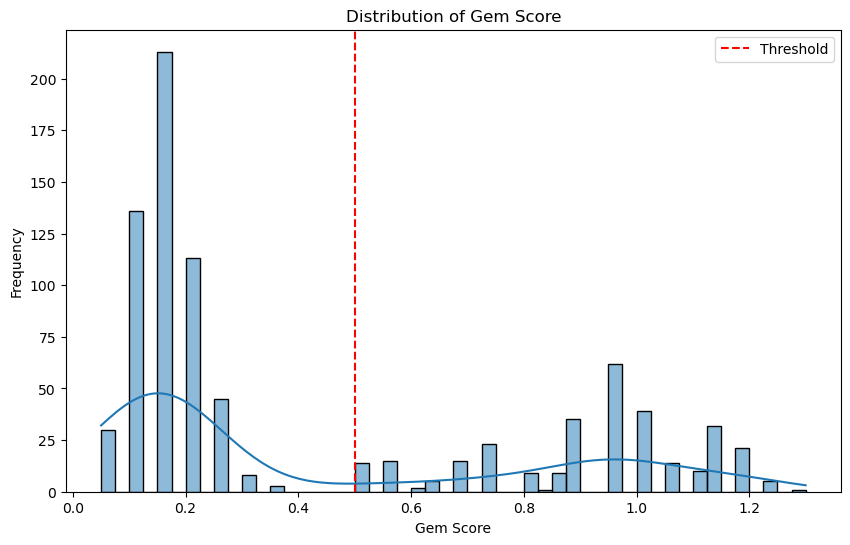

In [78]:
# 可视化gem_score的分布
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.histplot(df_cluster1['gem_score'], bins=50, kde=True)
plt.title('Distribution of Gem Score')
plt.xlabel('Gem Score')
plt.ylabel('Frequency')
plt.axvline(x=0.5, color='r', linestyle='--', label='Threshold')
plt.legend()
plt.show()

In [79]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
# 特征选择
features = [
    'attr_score', 'cat_score',
    'std_review_stars_scaled',
    'pos_review_ratio', 'neg_review_ratio', 'neu_review_ratio',
    'long_review_ratio', 'avg_review_length_scaled', 'avg_word_count_scaled',
    'avg_useful_scaled', 'avg_funny_scaled', 'avg_cool_scaled',
    'interact_score_mean_scaled', 'sentiment_score_mean_scaled',
    'recent_review_ratio', 'review_timespan_days_scaled', 'review_burst_score_scaled',
    'avg_user_avg_stars', 'elite_user_ratio', 'avg_user_account_age_days',
    'avg_user_review_count_log_scaled', 'avg_user_useful_log_scaled',
    'avg_user_funny_log_scaled', 'avg_user_cool_log_scaled',
    'avg_user_fans_log_scaled', 'avg_user_compliments_log_scaled'
]

X = df_cluster1[features]
y = df_cluster1['gem_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = XGBRegressor()
model.fit(X_train, y_train)  # y_train = df_cluster1['gem_score']
df_cluster1['gem_score_predict'] = model.predict(X)

/tmp/ipykernel_1708/361456542.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


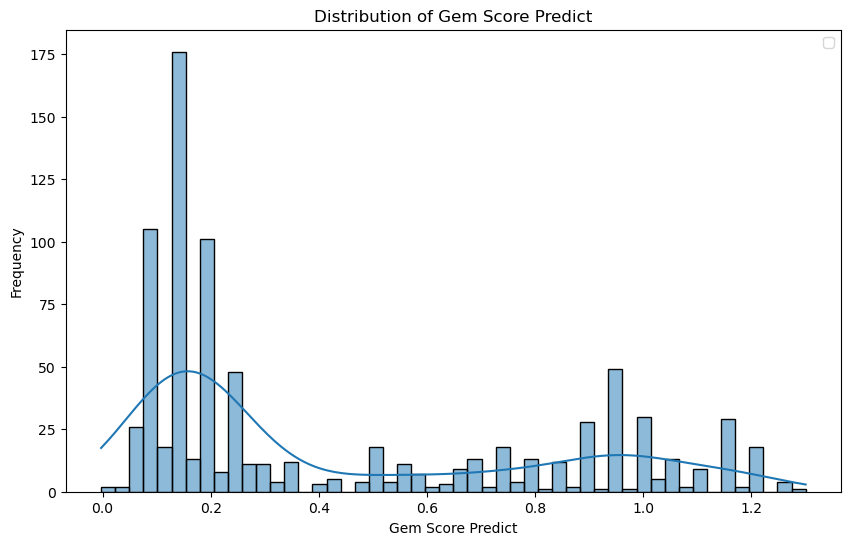

In [80]:
# 可视化gem_score_predict的分布
plt.figure(figsize=(10, 6))
sns.histplot(df_cluster1['gem_score_predict'], bins=50, kde=True)
plt.title('Distribution of Gem Score Predict')
plt.xlabel('Gem Score Predict')
plt.ylabel('Frequency') 
# plt.axvline(x=0.5, color='r', linestyle='--', label='Threshold')
plt.legend()
plt.show()

In [81]:
data_gem_path = '../clustering/gem_candidates.csv'
df_gem = pd.read_csv(data_gem_path)
df_gem = df_gem[df_gem['gem_label'] == 1].copy()
df_gem = df_gem[['business_id', 'gem_label']].copy()
print(len(df_gem))

135


In [82]:
# 从df_cluster1中选择gem_score_predict的top135
df_cluster1 = df_cluster1[['business_id', 'gem_score_predict']].copy()
df_top_gem = df_cluster1.sort_values(by='gem_score_predict', ascending=False).head(135).copy()

# 输出df_gem和df_top_gem的business_id的交集
df_gem_intersection = df_top_gem[df_top_gem['business_id'].isin(df_gem['business_id'])].copy()
print(len(df_gem_intersection))

82


In [83]:
df_gem_intersection

,business_id,gem_score_predict
2538,kWbCmkx7Pd1kzHDT919FLA,1.300334
4720,mgEDe8C777tgTsNg7o5z6g,1.250151
818,hcS499kBXC7gS2ZfKsbD4A,1.250091
55,CVeX9v44CyMbrx8kr0fQ8Q,1.249980
1888,rqKCzXC272dWC0pr-D03SA,1.249784
...,...,...
4442,SnII_EHa51aPSWeFATv8ZQ,0.950117
2986,b8Xtx3cJgovamFrfoF3iVA,0.950050
1530,YEoCF1Vs7as4szsYMJl1FQ,0.950014
4978,n0CdVw9AEmVRAIy7i1F6ag,0.949920


In [ ]:
#保存df_cluster1和df_gem_intersection
df_cluster1.to_csv('cluster1_scores_all.csv', index=False)
df_gem_intersection.to_csv('gem_candidates_final.csv', index=False)